In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or '3' to suppress all messages
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import random
import joblib
label_encoder = LabelEncoder()
pd.options.mode.chained_assignment = None


In [2]:
label_path = './data/data_by_table/pre_24h_data_v6.csv'
flag_data_path = './data/data_by_table/ground_truth.csv'
raw_data_path = './data/data_by_table/pre_24h_data_1217.csv'
mode_data_path = './data/data_by_table/pre_24_merged_30_rows_12_07.csv'

data_df = pd.read_csv(raw_data_path)
flag_data_df = pd.read_csv(flag_data_path)
label_df = pd.read_csv(label_path)
mode_df = pd.read_csv(mode_data_path)
data_df['BMI'] = data_df['weight_kg'] / ((data_df['height_cm'] / 100) ** 2)
data_df['gender'] = label_encoder.fit_transform(data_df['gender'])
data_df['race'] = label_encoder.fit_transform(data_df['race'])
data_df['first_careunit'] = label_encoder.fit_transform(data_df['first_careunit'])
data_df['admission_type'] = label_encoder.fit_transform(data_df['admission_type'])
data_df['ventilator_mode_group'] = label_encoder.fit_transform(data_df['ventilator_mode_group'])
data_df['ventilator_mode'] = label_encoder.fit_transform(data_df['ventilator_mode'])
data_df['insurance'] = label_encoder.fit_transform(data_df['insurance'])
data_df = data_df.drop(columns=['height_cm', 'weight_kg'])
data_df['RSBI'] =   data_df['resp_rate']/(data_df['tidal_volume_observed']* 0.001) 
data_df['minute_ventilation'] = data_df['tidal_volume_observed'] * data_df['resp_rate']* 0.001
data_df = data_df.drop(columns=[ 'hadm_id','subject_id'])
print(data_df.columns)

Index(['Unnamed: 0', 'charttime', 'before_weaning_hr', 'stay_id', 'O2_flow',
       'heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'spo2', 'peep', 'fio2',
       'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure',
       'ventilator_mode', 'GCS', 'age_now', 'gender', 'insurance', 'race',
       'admission_type', 'first_careunit', 'tobacco', 'label', 'Rev_h',
       'dod_h', 'RSBI', 'minute_ventilation', 'ventilator_mode_group', 'BMI'],
      dtype='object')


In [3]:
vitalsign = ['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate', 
             'tidal_volume_observed', 'RSBI', 'minute_ventilation']
ventilator_settings = ['peep', 'fio2', 'respiratory_rate_set', 'plateau_pressure']
baseline = ['age_now','gender', 'insurance', 'race', 'admission_type', 'first_careunit'
,'weight_kg', 'height_cm', 'tobacco' ]
all_feature = ['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate', 
             'tidal_volume_observed', 'RSBI', 'minute_ventilation','peep',
              'fio2', 'respiratory_rate_set', 'plateau_pressure','age_now','gender', 'insurance',
               'race', 'admission_type', 'first_careunit'
,'weight_kg', 'height_cm', 'tobacco']

In [4]:
set(['Unnamed: 0', 'before_weaning_hr', 'O2_flow', 'heart_rate', 'sbp',
       'dbp', 'mbp', 'resp_rate', 'spo2', 'peep', 'fio2',
       'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure',
       'ventilator_mode', 'GCS', 'age_now', 'gender', 'insurance', 'race',
       'admission_type', 'first_careunit', 'tobacco', 'RSBI',
       'minute_ventilation', 'ventilator_mode_group', 'BMI']) - set(all_feature)

{'BMI',
 'GCS',
 'O2_flow',
 'Unnamed: 0',
 'before_weaning_hr',
 'ventilator_mode',
 'ventilator_mode_group'}

In [5]:
print(data_df['ventilator_mode_group'])

0        1
1        1
2        1
3        1
4        1
        ..
68155    1
68156    1
68157    1
68158    1
68159    1
Name: ventilator_mode_group, Length: 68160, dtype: int64


# create reasonable data list

In [6]:
def check_missing_values(df):
    
    if df.isna().any().any():
        return 1 
    else:
        return 0 

def get_label(id_df):
    label = 0
    if not check_missing_values(id_df):
            label = id_df['label'].iloc[0]
            if label == 1:
                label = 48
            else:
                if id_df['Rev_h'].iloc[0] != -1000:
                    label = -(48 - id_df['Rev_h'].iloc[0])
                    #label = -48
                elif id_df['dod_h'].iloc[0] != -1000 and id_df['dod_h'].iloc[0]>0 and id_df['dod_h'].iloc[0]<48:
                    label = -(96 - id_df['dod_h'].iloc[0]*2)
                    #label = -96
                else:
                    label = -96
                     
    return label
    
def create_patient_group(label_df,mode_df,kick = 0):
    alive_list = [[],[],[],[],[],[]]
    dead_list = [[],[],[],[],[],[]]
    alive_num = [0,0,0,0,0]
    dead_num = [0,0,0,0,0]
    patient_set = set(mode_df['stay_id'])
    for index, row in flag_data_df.iterrows():
        if row['stay_id'] not in patient_set:
            continue
        id_mode_df = mode_df[mode_df['stay_id'] == row['stay_id']]
        count_complete_mode = id_mode_df['ventilator_mode_group'].tail(12).value_counts().get('Complete Support', 0)
        group_num = int(math.floor(count_complete_mode/3))
        label = id_mode_df['label'].iloc[0]
        if get_label(label_df[label_df['stay_id'] == row['stay_id']]) == -96 and kick:
            continue
        if label == 1:
            alive_list[group_num].append(row['stay_id'])
            alive_num[group_num]+=1
        else:
            dead_list[group_num].append(row['stay_id'])
            dead_num[group_num]+=1
    return alive_list, dead_list, alive_num, dead_num
    
def split_list(input_list):
    random.shuffle(input_list)
    total_length = len(input_list)
    part1_length = int(total_length * 0.7)
    part2_length = int(total_length * 0.2)
    part3_length = total_length - part1_length - part2_length
    part1 = random.sample(input_list, part1_length)
    remaining_list = [element for element in input_list if element not in part1]

    part2 = random.sample(remaining_list, part2_length)
    part3 = [element for element in remaining_list if element not in part2]
    #print(total_length, len(part1),len(part2),len(part3))
    return part1, part2, part3

def create_data(alive_list, dead_list):
    train_data_id = []
    val_data_id = []
    test_data_id = []
    train_data_id_2 = []
    val_data_id_2 = []
    test_data_id_2 = []
    for i in range(5):
        train, val, test = split_list(alive_list[i])
        train_data_id+=train
        val_data_id+=(val)
        test_data_id+=(test)
        train, val, test = split_list(dead_list[i])
        train_data_id_2+=train
        val_data_id_2+=(val)
        test_data_id_2+=(test)
    
    #print(len(train_data_id)/(len(train_data_id)+len(train_data_id_2)))
    #print(len(val_data_id)/(len(val_data_id)+len(val_data_id_2)))
    #print(len(test_data_id)/(len(test_data_id)+len(test_data_id_2)))
    return train_data_id+train_data_id_2, val_data_id+val_data_id_2, test_data_id+test_data_id_2

In [7]:
alive_list, dead_list, alive_num, dead_num = create_patient_group(label_df,mode_df)
train_data_id, val_data_id, test_data_id = create_data(alive_list, dead_list)
num = 0
for i in range (5):
    num += len(dead_list[i])
print(num)
print(len(train_data_id), len(val_data_id),len(test_data_id)) #1603 455 239

971
1860 529 274


In [8]:
def check_duplicate_elements(list1, list2, list3):
    common_elements_12 = set(list1) & set(list2)
    common_elements_13 = set(list1) & set(list3)
    common_elements_23 = set(list2) & set(list3)

    if common_elements_12:
        print(f"列表1和列表2有相同的元素：{common_elements_12}")
    else:
        print("列表1和列表2沒有相同的元素")

    if common_elements_13:
        print(f"列表1和列表3有相同的元素：{common_elements_13}")
    else:
        print("列表1和列表3沒有相同的元素")

    if common_elements_23:
        print(f"列表2和列表3有相同的元素：{common_elements_23}")
    else:
        print("列表2和列表3沒有相同的元素")

check_duplicate_elements(train_data_id, val_data_id, test_data_id)

列表1和列表2沒有相同的元素
列表1和列表3沒有相同的元素
列表2和列表3沒有相同的元素


# save and read data

In [9]:
csv_file_name = 'group_data/77_77_77/train_data_id.csv'
with open(csv_file_name, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for row in zip(train_data_id):
        csv_writer.writerow(row)
csv_file_name = 'group_data/77_77_77/val_data_id.csv'
with open(csv_file_name, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for row in zip(val_data_id):
        csv_writer.writerow(row)
csv_file_name = 'group_data/77_77_77/test_data_id.csv'
with open(csv_file_name, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for row in zip(test_data_id):
        csv_writer.writerow(row)

In [10]:
def read_from_csv(file_name):
    data = []
    with open(file_name, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # 將每個元素轉換為數字
            row = [int(element) for element in row]
            data.append(row[0])
    return data

group_prefix = 'group_data/1216best/'

# 讀取訓練數據
train_csv_file = group_prefix + 'train_data_id.csv'
train_data_id = read_from_csv(train_csv_file)

# 讀取驗證數據
val_csv_file = group_prefix + 'val_data_id.csv'
val_data_id = read_from_csv(val_csv_file)

# 讀取測試數據
test_csv_file = group_prefix + 'test_data_id.csv'
test_data_id = read_from_csv(test_csv_file)

# seperate data

In [26]:
def get_diff_value(df, colname, start, end):
    start = 23 - start
    end = 23 - end
    df = df.reset_index()
    return (df[colname].iloc[end] + df[colname].iloc[end-1] + df[colname].iloc[end-2]) - (df[colname].iloc[start] + df[colname].iloc[start+1] + df[colname].iloc[start+2])

def get_more_feature(df, colnames, start, end):
    add_list = []
    for name in colnames:
        now = get_diff_value(df, name, start, end)
        add_list.append(now)
    return np.array(add_list)

def false_percentage(y_label):
    zero = len(y_label) - np.count_nonzero(y_label)
    print(f"false percentage: {(zero/len(y_label)) * 100:.2f}%")

def calculate_tpr_tnr(y_true, y_pred):
    # 计算 TP, FN, TN, FP
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))

    # 计算 TPR 和 TNR
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0

    return TPR, TNR

def calculate_tpr_tnr2(y_true, y_pred):
    # 计算 TP, FN, TN, FP
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))

    # 计算 TPR 和 TNR
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0

    return TPR, TNR

def get_label(id_df):
    label = 0
    if not check_missing_values(id_df):
            label = id_df['label'].iloc[0]
            if label == 1:
                label = 48
            else:
                if id_df['Rev_h'].iloc[0] != -1000:
                    label = -(48 - id_df['Rev_h'].iloc[0])
                elif id_df['dod_h'].iloc[0] != -1000 and id_df['dod_h'].iloc[0]>0 and id_df['dod_h'].iloc[0]<48:
                    label = -(96 - id_df['dod_h'].iloc[0]*2)
                else:
                    label = -96 
    return label
def calculate_std_deviation(df, col_name):
    selected_col = df[col_name]
    std_deviation = selected_col.std()
    return std_deviation
def calculate_mean_difference(df, col_name):
    selected_col = df[col_name]

    # 取前三個和最後三個值
    first_three_values = selected_col.head(3)
    last_three_values = selected_col.tail(3)

    # 計算平均值
    first_three_mean = first_three_values.mean()
    last_three_mean = last_three_values.mean()

    # 計算平均值差
    mean_difference = last_three_mean - first_three_mean

    return mean_difference
def get_data(flag_data_df, data_df,label_df, mode_df,train_data_id, val_data_id, test_data_id,hour = 23):
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    test_x = []
    test_y = []
    count = 0
    cc = 0
    all_feature = ['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate', 
             'tidal_volume_observed', 'RSBI', 'minute_ventilation','peep',
              'fio2', 'respiratory_rate_set', 'plateau_pressure','age_now','gender', 'insurance',
               'race', 'admission_type', 'first_careunit'
                ,'BMI', 'tobacco','BMI','GCS']
    std_feature = ['peep','plateau_pressure','resp_rate','heart_rate']
    for index, row in flag_data_df.iterrows():
        id_df = data_df[data_df['stay_id'] == row['stay_id']]
        id_mode_df = mode_df[mode_df['stay_id'] == row['stay_id']]['ventilator_mode_group']
        id_df_label = label_df[label_df['stay_id'] == row['stay_id']]
        if not check_missing_values(id_df) or 1:
            label = get_label(id_df_label)
            id_now = id_df['stay_id'].iloc[0]
            id_df = id_df[all_feature]
            #if(id_df.shape[0] != 24):
                #continue
            
            zero_hr_values = id_df.iloc[hour, :].values
            count_complete_mode =  mode_df[mode_df['stay_id'] == row['stay_id']]['ventilator_mode_group'].tail(12).value_counts().get('Complete Support', 0)
            #if(id_df.shape[0] != 24):
                #continue
            zero_hr_values = id_df.iloc[hour, :].values
            try:
                count+=1
                if(id_mode_df.iloc[-1] == 'Complete Support'):
                    mode_code = 1
                    cc+=1
            except:
                continue
            #zero_hr_values = np.append(zero_hr_values, mode_code)
            zero_hr_values = np.append(zero_hr_values, count_complete_mode)
            zero_hr_values = np.append(zero_hr_values, calculate_std_deviation(mode_df[mode_df['stay_id'] == row['stay_id']], 'peep'))
            zero_hr_values = np.append(zero_hr_values, calculate_std_deviation(mode_df[mode_df['stay_id'] == row['stay_id']], 'plateau_pressure'))
            #zero_hr_values = np.append(zero_hr_values, calculate_std_deviation(mode_df[mode_df['stay_id'] == row['stay_id']], 'resp_rate'))
            #zero_hr_values = np.append(zero_hr_values, calculate_std_deviation(mode_df[mode_df['stay_id'] == row['stay_id']], 'heart_rate'))
            #zero_hr_values = np.append(zero_hr_values, calculate_std_deviation(mode_df[mode_df['stay_id'] == row['stay_id']], 'RSBI'))
            #zero_hr_values = np.append(zero_hr_values, calculate_std_deviation(mode_df[mode_df['stay_id'] == row['stay_id']], 'respiratory_rate_set'))
            #zero_hr_values = np.append(zero_hr_values, calculate_std_deviation(mode_df[mode_df['stay_id'] == row['stay_id']], 'minute_ventilation'))
            if id_now in train_data_id:
                train_x.append(zero_hr_values)
                train_y.append(label)
            elif id_now in val_data_id:
                val_x.append(zero_hr_values)
                val_y.append(label)
            elif id_now in test_data_id:
                test_x.append(zero_hr_values)
                test_y.append(label)
    #total_x = np.array(total_x)
    #total_y = np.array(total_y).reshape(-1, 1)
    #print(cc/count*100)
    return train_x, train_y, val_x, val_y, test_x, test_y

In [27]:
train_x, train_y, val_x, val_y, test_x, test_y = get_data(flag_data_df, data_df,label_df, mode_df,train_data_id, val_data_id, test_data_id)
print(len(train_x), len(val_x), len(test_x)) #1860 529 274

1860 529 274


In [24]:
def print_percentage_of_negative_values(arr):
    # 檢查輸入是否為 NumPy 陣列
    if not isinstance(arr, np.ndarray):
        print("請輸入有效的 NumPy 陣列。")
        return
    
    # 計算小於 0 的值的百分比
    negative_percentage = np.count_nonzero(arr < 0) / arr.size * 100
    
    # 印出結果
    print(f"陣列中 {negative_percentage:.2f}% 的值小於 0。")
    
def normalize_data(train_x, train_y, val_x, val_y, test_x, test_y):
    total_x = train_x+val_x+test_x
    total_x = np.array(total_x)
    total_x = total_x.astype(np.float32)
    total_x[np.isinf(total_x)] = np.nan
    total_x[np.abs(total_x) > 1e6] = np.nan
    total_x[np.isnan(total_x)] = 0.0
    scaler = MinMaxScaler()
    total_x_normalized = scaler.fit_transform(total_x.reshape(-1, total_x.shape[-1])).reshape(total_x.shape)

    X_train = total_x_normalized[:len(train_x)]
    X_val = total_x_normalized[len(train_x):len(train_x)+len(val_x)]
    X_test = total_x_normalized[len(train_x)+len(val_x):len(train_x)+len(val_x)+len(test_x)]
    y_train = np.array(train_y).reshape(-1, 1)
    y_val = np.array(val_y).reshape(-1, 1)
    y_test = np.array(test_y).reshape(-1, 1)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [29]:
total_x = train_x+val_x+test_x
total_x = np.array(total_x)
total_x = total_x.astype(np.float32)
total_x[np.isinf(total_x)] = np.nan
total_x[np.abs(total_x) > 1e6] = np.nan
total_x[np.isnan(total_x)] = 0.0
scaler = MinMaxScaler()
#scaler = joblib.load('./model/C_scaler.joblib')
total_x_normalized = scaler.fit_transform(total_x.reshape(-1, total_x.shape[-1])).reshape(total_x.shape)
#joblib.dump(scaler, './model/C_scaler.joblib')

X_train = total_x_normalized[:len(train_x)]
X_val = total_x_normalized[len(train_x):len(train_x)+len(val_x)]
X_test = total_x_normalized[len(train_x)+len(val_x):len(train_x)+len(val_x)+len(test_x)]
y_train = np.array(train_y).reshape(-1, 1)
y_val = np.array(val_y).reshape(-1, 1)
y_test = np.array(test_y).reshape(-1, 1)

print(X_train.shape)
#print_percentage_of_negative_values(y_train)
print(X_val.shape)
#print_percentage_of_negative_values(y_val)
print(X_test.shape)
#print_percentage_of_negative_values(y_test)

(1860, 26)
(529, 26)
(274, 26)


# train mode

In [15]:
import tensorflow as tf

def train_NN_module(X_train, y_train, X_test, y_test, epoch, learning_rate, batch, verbose=1):
    # Define model and train
    def build_nn_model(input_shape):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='mean_squared_error')
        return model

    # Build and compile the model
    model = build_nn_model(input_shape=(X_train.shape[1],))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=epoch, batch_size=batch, validation_data=(X_test, y_test), verbose=verbose)
    return model

In [16]:
from sklearn.metrics import classification_report

def print_classification_metrics(y_true, y_pred, prefix):
    print(f"{prefix} Classification Report:")
    print(classification_report(y_true, y_pred))
    print()

def print_score(model, X_data, y_data, who):
    print("========="+who+"=========")
    y_pred_proba = model.predict(X_data, verbose=0)
    y_pred = np.where(y_pred_proba >0 , 1, 0)
    y_label = np.where(y_data > 0, 1, 0)

    accuracy = np.mean(y_pred == y_label)
    tpr, tnr = calculate_tpr_tnr(y_label, y_pred)
    print("TPR:", tpr)
    print("TNR:", tnr)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    auroc = roc_auc_score(y_label, y_pred_proba)
    print("AUROC:", auroc)
    print_classification_metrics(y_label,y_pred, who)
def get_score(model, X_data, y_data, who):
    y_pred_proba = model.predict(X_data, verbose=0)
    y_pred = np.where(y_pred_proba >0 , 1, 0)
    y_label = np.where(y_data > 0, 1, 0)

    accuracy = np.mean(y_pred == y_label)
    tpr, tnr = calculate_tpr_tnr(y_label, y_pred)
    auroc = roc_auc_score(y_label, y_pred_proba)
    return auroc


In [32]:
model = train_NN_module(X_train, y_train, X_val, y_val, epoch=45, learning_rate=0.001, batch=32)

Epoch 1/45
59/59 [==============================] - 2s 31ms/step - loss: 3055.1482 - val_loss: 3100.1865
Epoch 2/45
59/59 [==============================] - 1s 25ms/step - loss: 2826.6919 - val_loss: 2732.4771
Epoch 3/45
10/59 [====>.........................] - ETA: 1s - loss: 2576.2666

KeyboardInterrupt: 

In [31]:
print_score(model, X_train,y_train,'train')
print_score(model, X_val,y_val,'val')
print_score(model, X_test,y_test,'test')

=========train=========
TPR: [0.87309645]
TNR: [0.51179941]
Accuracy: 74.14%
AUROC: 0.763713569820663
train Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.51      0.59       678
           1       0.76      0.87      0.81      1182

    accuracy                           0.74      1860
   macro avg       0.73      0.69      0.70      1860
weighted avg       0.74      0.74      0.73      1860


=========val=========
TPR: [0.8452381]
TNR: [0.53367876]
Accuracy: 73.16%
AUROC: 0.7772020725388602
val Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.53      0.59       193
           1       0.76      0.85      0.80       336

    accuracy                           0.73       529
   macro avg       0.71      0.69      0.70       529
weighted avg       0.72      0.73      0.72       529


=========test=========
TPR: [0.89655172]
TNR: [0.56]
Accuracy: 77.37%
AUROC: 0.7929885

PermutationExplainer explainer: 275it [00:39,  4.18it/s]                         


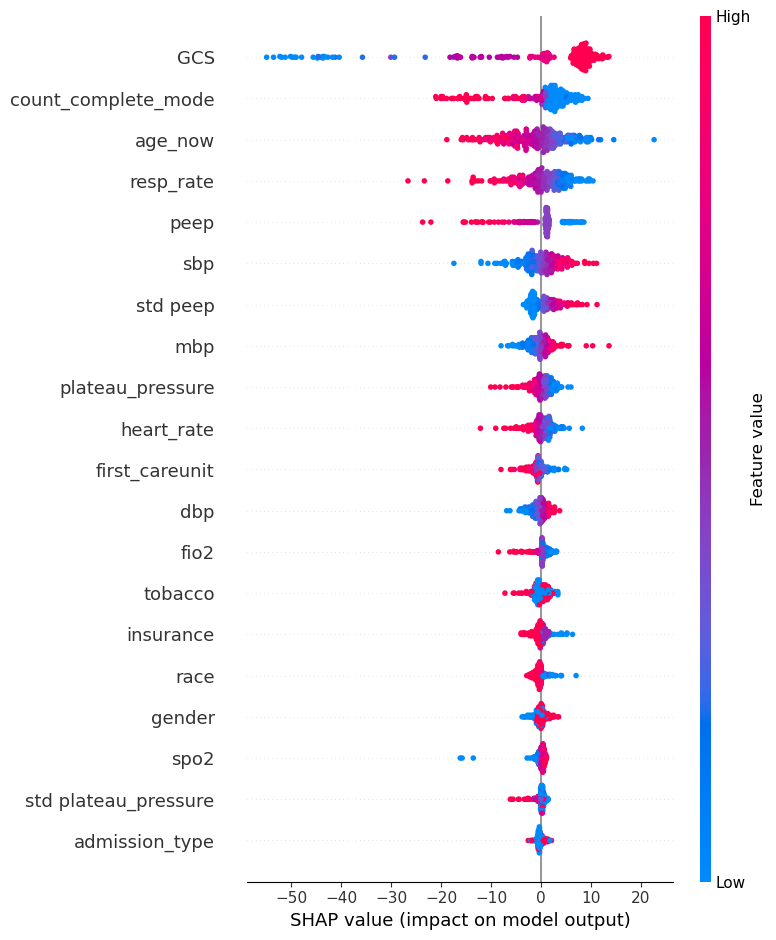

In [33]:
import shap
from keras.models import load_model

# 載入模型
model_test = load_model('./model/1219test_temp.h5')

# 創建 SHAP 解釋器，使用 Independent masker
explainer = shap.Explainer(model_test, masker=shap.maskers.Independent(data=X_train), feature_names=['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate', 'tidal_volume_observed', 'RSBI', 'minute_ventilation','peep', 'fio2', 'respiratory_rate_set', 'plateau_pressure','age_now','gender', 'insurance', 'race', 'admission_type', 'first_careunit' ,'BMI', 'tobacco','BMI','GCS','count_complete_mode','std peep','std plateau_pressure','std resp_rate','std heart_rate'])

# 提供一個樣本數據（X）以生成 SHAP 值
shap_values = explainer.shap_values(X_test)

# 生成 SHAP 圖表
shap.summary_plot(shap_values, X_test, feature_names=['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate', 
             'tidal_volume_observed', 'RSBI', 'minute_ventilation','peep',
              'fio2', 'respiratory_rate_set', 'plateau_pressure','age_now','gender', 'insurance',
               'race', 'admission_type', 'first_careunit'
                ,'BMI', 'tobacco','BMI','GCS','count_complete_mode','std peep','std plateau_pressure','std resp_rate','std heart_rate'])


PermutationExplainer explainer: 275it [00:20,  5.85it/s]                         


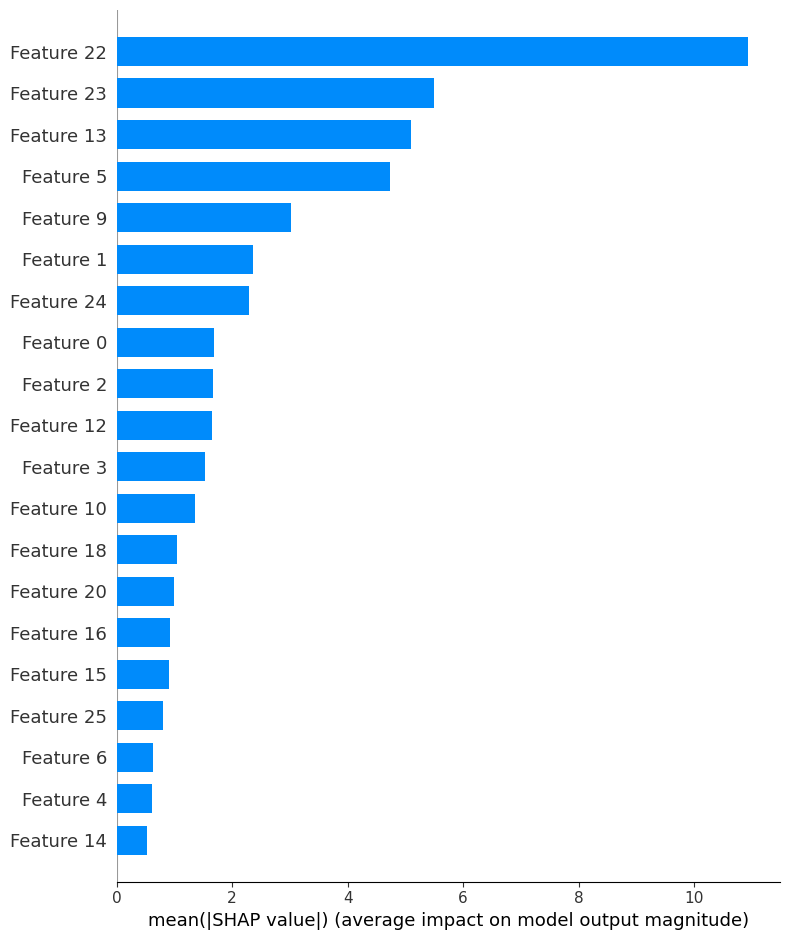

In [ ]:
import shap
from keras.models import load_model

# 載入模型
model_test = load_model('./model/1219test_2.h5')

# 創建 SHAP 解釋器，使用 Independent masker
explainer = shap.Explainer(model, masker=shap.maskers.Independent(data=X_train))

# 提供一個樣本數據（X）以生成 SHAP 值
shap_values = explainer.shap_values(X_test)

# 生成 SHAP 平均圖表
shap.summary_plot(shap_values, X_test, plot_type='bar')


# save model

In [ ]:
from tensorflow.keras.models import load_model
#model.save('./model/1219test_2.h5')